In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image as tfimage
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
# Use pre-trained ResNet-50 without the last softmax layer
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3), pooling='avg')
def extract_features(img_path, model, box=False, imshow=False):
    input_shape = (224, 224, 3)
    img = tfimage.load_img(img_path)
    if imshow:
      plt.imshow(img)
      plt.show()
    # add bounding box
    box_path = img_path.replace('jpg', 'txt')
    # if os.path.isfile(box_path):
    if box:
      with open(box_path, 'r') as reader:
        content = reader.readline()[:-1].split(' ')
        location = [int(i) for i in content]
      box = ( location[0],location[1],  location[0]+location[2], location[1]+location[3])
      img = img.crop(box)
    img = img.resize((input_shape[0], input_shape[1]))
    if imshow:
      plt.imshow(img)
      plt.show()
    img_array = tfimage.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
n_images = 5000
n_box = 2000
n_queries = 10
feature_list = []
filenames = []
for i in tqdm_notebook(range(1, n_images+1)):
    number_str = "{0:0>4d}".format(i)
    image_path = '/content/drive/MyDrive/ug_data/Images/{}.jpg'.format(number_str)
    filenames.append(image_path)
    if i <= n_box:
      feature_list.append(extract_features(image_path, model, box=True))
    else:
      feature_list.append(extract_features(image_path, model, box=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## Run below this cell once if features of images are not taken

In [ ]:
pickle.dump(feature_list, open('/content/drive/MyDrive/features-search.pickle', 'wb'))
pickle.dump(filenames, open('/content/drive/MyDrive/filenames-search.pickle','wb'))

## If you don't want to run above, you can download the result

In [3]:
filenames = pickle.load(open('filenames-search.pickle', 'rb'))
feature_list = pickle.load(open('features-search.pickle', 'rb'))

## Get rankList.txt of images

In [4]:
features_array = np.vstack( feature_list )

In [5]:
query_feature_list = []
for i in range(1,21):
    number_str = "{0:0>2d}".format(i)
    image_path = 'ug_data/Queries/{}.jpg'.format(number_str)
    feature = extract_features(image_path, model, box=True)
    query_feature_list.append(feature)

query_features = np.vstack( query_feature_list )
euc_dist = cdist(query_features, features_array, metric='euclidean')
ranked_images = np.argsort(euc_dist) + 1

In [6]:
file = open("rankList-cnn.txt","a")
for i in range(20):
    line = 'Q{}: '.format(i+1) + ' '.join(map(str, ranked_images[i])) + '\n'
    file.write(line)

file.close()

# Get rankList for examples

In [7]:
query_feature_list = []
for i in range(1,11):
    number_str = "{0:0>2d}".format(i)
    image_path = 'ug_data/examples/example_query/{}.jpg'.format(number_str)
    feature = extract_features(image_path, model, box=True)
    query_feature_list.append(feature)

query_features = np.vstack( query_feature_list )

In [8]:
features_array = np.vstack( feature_list )
euc_dist = cdist(query_features, features_array, metric='euclidean')
ranked_images = np.argsort(euc_dist) + 1

In [9]:
file = open("rankList-example-cnn.txt","a")
for i in range(10):
    line = 'Q{}: '.format(i+1) + ' '.join(map(str, ranked_images[i])) + '\n'
    file.write(line)

file.close()


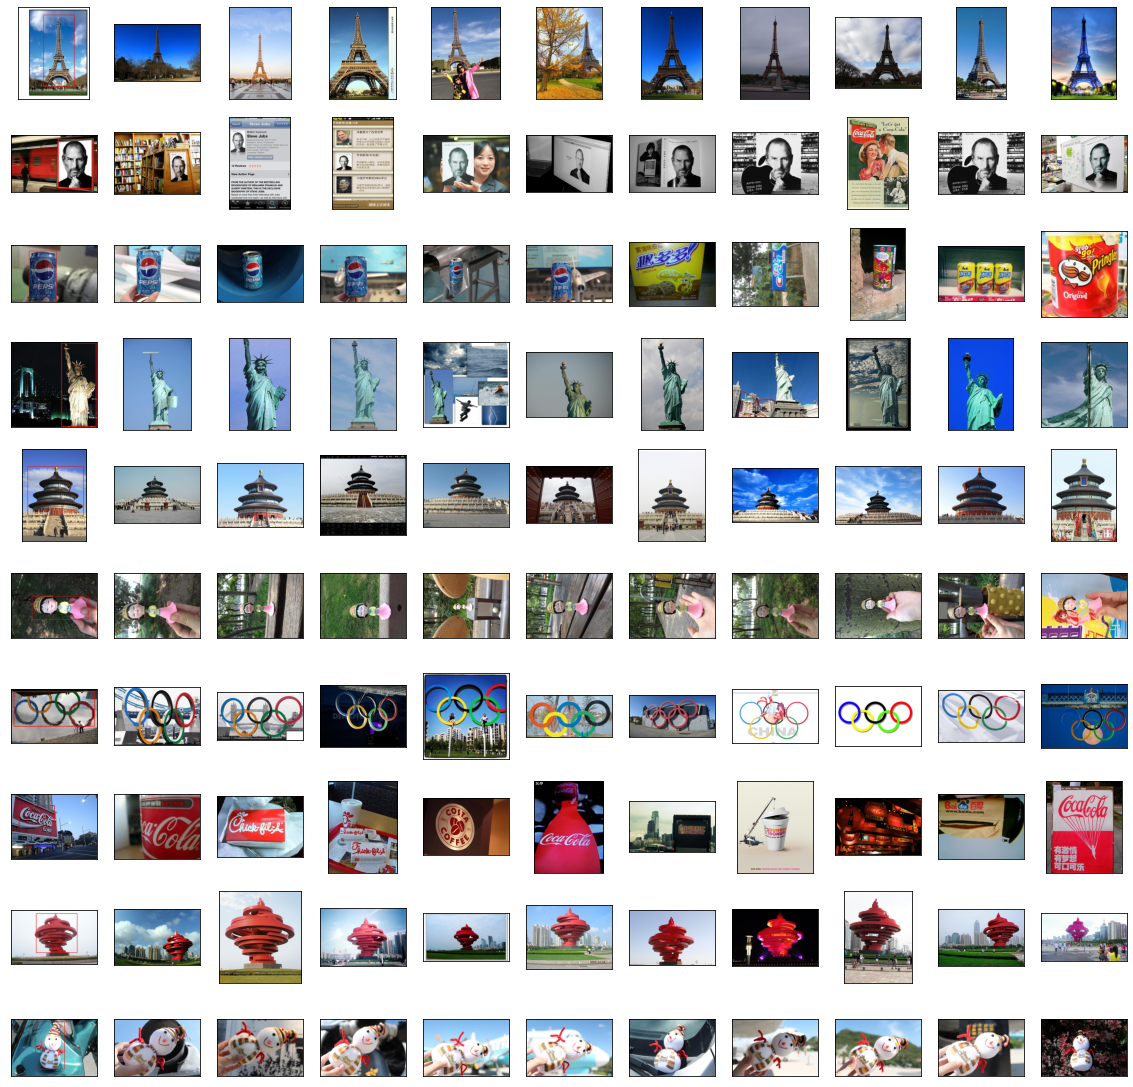

In [19]:
plt.figure(figsize=(20,20))
for i in range(1,11):
    number_str = "{0:0>2d}".format(i)
    image_path = 'ug_data/Queries/{}.jpg'.format(number_str)
    plt.subplot(10,11, (i-1)*11+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(image_path))
    # plt.show()
    for j, ex in enumerate(ranked_images[i-1, :10]):
        image_path = 'ug_data/Images/{0:0>4d}.jpg'.format(ex)
        plt.subplot(10,11, (i-1)*11+j+2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mpimg.imread(image_path));
plt.savefig('top-10-cnn.jpg');